In [32]:
import numpy as np 
import nrrd

In [33]:
path_rank1="rank-1.nrrd"
path_rank2="rank-2.nrrd"
path_rank3="rank-3.nrrd"
path_avg="avg-1-20.nrrd"
path_wm="wmvolume.nrrd"
selected_index=2

In [34]:
# load all datasets

rank1,_ = nrrd.read(path_rank1)
rank2,_ = nrrd.read(path_rank2)
rank3,_ = nrrd.read(path_rank3)
average_model,_ = nrrd.read(path_avg)
wm, meta = nrrd.read(path_wm)

In [1]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))#
            0.0'
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.abs(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))*180/np.pi

In [36]:
ranks = np.concatenate((rank1,rank2,rank3), axis=1)
retval = np.zeros((*wm.shape,3))
for selected_index in range(1):
    for i,j,k in np.ndindex(ranks.shape[2:]):
        if wm[i,j,k] > 0.3:
            out = []
            for l in range(ranks.shape[1]):
                out.append(angle_between(average_model[1:, selected_index, i, j, k], ranks[1:, l, i,j,k]))
            retval[i,j,k,selected_index] = min(out)
        

In [88]:
ranks.shape

(4, 6, 145, 174, 145)

In [53]:
np.quantile(retval[wm>0.1,:].flatten(),0.99)

5.061015133337175

In [31]:
import matplotlib.pyplot as plt 


(array([1.35752e+05, 4.53920e+04, 3.39860e+04, 2.70200e+04, 2.25290e+04,
        1.85800e+04, 1.60360e+04, 1.42740e+04, 1.24920e+04, 1.09710e+04,
        9.81200e+03, 8.79700e+03, 7.96500e+03, 7.23500e+03, 6.65500e+03,
        6.02200e+03, 5.49400e+03, 5.10700e+03, 4.69600e+03, 4.37900e+03,
        4.03500e+03, 3.80200e+03, 3.46600e+03, 3.35500e+03, 3.08500e+03,
        2.80700e+03, 2.58800e+03, 2.43900e+03, 2.29000e+03, 2.19200e+03,
        2.06500e+03, 1.84200e+03, 1.79600e+03, 1.65200e+03, 1.51100e+03,
        1.35800e+03, 1.28200e+03, 1.18000e+03, 1.01900e+03, 1.00900e+03,
        9.40000e+02, 8.22000e+02, 8.02000e+02, 7.44000e+02, 6.71000e+02,
        5.80000e+02, 5.46000e+02, 4.88000e+02, 4.75000e+02, 4.21000e+02,
        3.80000e+02, 3.57000e+02, 2.98000e+02, 2.69000e+02, 2.60000e+02,
        2.15000e+02, 1.95000e+02, 1.81000e+02, 1.69000e+02, 1.34000e+02,
        1.14000e+02, 1.03000e+02, 1.06000e+02, 9.70000e+01, 8.00000e+01,
        5.30000e+01, 5.60000e+01, 4.60000e+01, 4.50

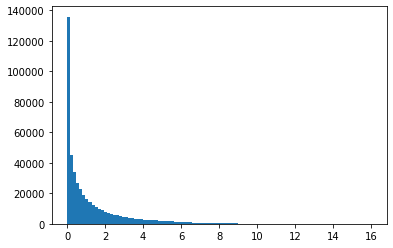

In [54]:

plt.hist(retval[wm>0.3,0].flatten(), bins=100)

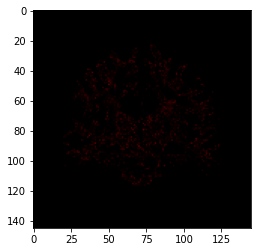

In [92]:
plt.imshow(np.rot90(retval[:,87,:])/30)


In [3]:
## Last experiment is now: low-rank-johannes/scripts/fa_tract_calc


from math import floor

def linear(point, vlinear, data):# nogil except *:

    for i in range(8):
        j = int(floor(i / 2) % 2)
        k = int(floor(i / 4) % 2)
        m = int(point[0] + i%2)
        n = int(point[1] + j)
        o = int(point[2] + k)
        vlinear[i] =  data[m,n,o]
   # print(vlinear)
    for i in range(4):
        vlinear[i] = (point[2] - floor(point[2])) * vlinear[4+i] + (1 + floor(point[2]) - point[2]) * vlinear[i]
    for i in range(2):
        vlinear[i] = (point[1] - floor(point[1]))* vlinear[2 + i ] +  (1 + point[1] - floor(point[1])) * vlinear[i]
    return  (point[0] - floor(point[0])) * vlinear[1] +  (1 + floor(point[0]) - point[0]) * vlinear[0]

from plyfile import PlyData
import nibabel as nib 
import numpy as np

In [2]:
path_ref='/mnt/uni/data/xderes/bootstrap/922854/tracts/CST_right.tck'
path_avg='/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-avg-1-20-bootstrap-Trilinear_0.ply'
path_rank='/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-rank-3-Trilinear_0.ply'
path_fa='/mnt/uni/data/xderes/bootstrap/922854/ankele/dti_FA.nii.gz'

In [3]:
with open(path_avg, 'rb') as f:
    plydata = PlyData.read(f)

    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-avg-1-20-bootstrap-Trilinear_0.ply'

In [6]:
fa_map = nib.load(path_fa)
## questionable: TODO doublecheck mapping. 
trafo = np.linalg.inv(fa_map.affine)
fa_map = fa_map.get_fdata()
ret_val = []
y=np.zeros((8,))
for i in range(num_verts): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))



FileNotFoundError: No such file or no access: '/mnt/uni/data/xderes/bootstrap/922854/ankele/dti_FA.nii.gz'

In [7]:
from nibabel import streamlines as s

In [8]:
inval = s.load(path_ref)
vertices = np.ones((np.concatenate(inval.streamlines).shape[0], 4))
vertices[:, :3] = np.concatenate(inval.streamlines)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/tracts/CST_right.tck'

In [9]:
ret_val = []
y=np.zeros((8,))
for i in range(vertices.shape[0]): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))

NameError: name 'vertices' is not defined

In [10]:
with open(path_rank, 'rb') as f:
    plydata = PlyData.read(f)

    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-rank-3-Trilinear_0.ply'

In [11]:
ret_val = []
y=np.zeros((8,))
for i in range(num_verts): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))

NameError: name 'num_verts' is not defined

In [12]:
###matching code

In [4]:
from bonndit.tracking.interpolation import Trilinear
from bonndit.tracking.alignedDirection import ScalarOld
import nrrd
import numpy as np
from plyfile import PlyElement, PlyData

In [5]:
filename = '/mnt/uni/xderes/bootstrap/922854/output/922854-CC_2-rank-3-bootstrap-Trilinear_0.ply'
rank_file = '/mnt/uni/xderes/bootstrap/922854/ankele/rank-3-0.nrrd'
wm_file = '/mnt/uni/xderes/bootstrap/922854/ankele/wmvolume.nrrd'
with open(filename, 'rb') as f:
    plydata = PlyData.read(f)
    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']
    

In [6]:
directionGetter = ScalarOld(0,1) 
vectorfield, trafo = nrrd.read(rank_file)
trafo_data = np.zeros((4,4), dtype=np.float64)
trafo_data[3,3] = 1
trafo_data[:3,:3] = trafo['space directions'][2:]
tracking_parameters = {
		'trafo_data': trafo_data,
	}

In [7]:
wm, _ = nrrd.read(wm_file)

In [11]:
from bonndit.tracking.interpolation import Trilinear
from bonndit.tracking.alignedDirection import ScalarOld
import nrrd
import numpy as np
from plyfile import PlyElement, PlyData

from tqdm import tqdm

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))#
            0.0'
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.abs(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))*180/np.pi
def orth(k):
    x = np.random.randn(3)  # take a random vector
    x -= x.dot(k) * k       # make it orthogonal to k
    x /= np.linalg.norm(x)
    y = np.cross(k, x)
    return x,y

my_angle = 0.167
applyed_ang = []
filename = '/mnt/uni/xderes/bootstrap/922854/output/922854-CST_left-rank-3-Trilinear_0.ply'
rank_file = '/mnt/uni/xderes/bootstrap/922854/ankele/rank-3-0.nrrd'
wm_file = '/mnt/uni/xderes/bootstrap/922854/ankele/wmvolume.nrrd'
with open(filename, 'rb') as f:
    plydata = PlyData.read(f)
    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']


directionGetter = ScalarOld(0,1)
vectorfield, trafo = nrrd.read(rank_file)
trafo_data = np.zeros((4,4), dtype=np.float64)
trafo_data[3,3] = 1
trafo_data[:3,:3] = trafo['space directions'][2:]
trafo_data[:3,3] = trafo['space origin']

print(trafo)
tracking_parameters = {
		'trafo_data': trafo_data,
	}


wm, _ = nrrd.read(wm_file)

ref_noised = []
ref_unnoised = []
noised_unnoised = []
for i in tqdm(range(1000)):
    # chose random point
    point_ind = np.random.choice(range(num_verts))
    # dont consider end points of stream lines
    if point_ind in endindex or point_ind + 1 in endindex or point_ind + 2 in endindex:
        continue

    # interpolate
    #print(1)
    trilinear = Trilinear(np.array(vectorfield, dtype=np.float64), np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
    trilinear.interpolate(vertices[point_ind, :3], np.array([1, 1, 0, 0], dtype=np.float64), 1)
    #print(2)
    # do a step:
 #   print(point_ind)
    mp = np.array(np.linalg.inv(trafo_data) @ vertices[point_ind + 1], dtype=int)
   # print(mp)
    # noise the second vectorfield
    vectorfield2 = np.copy(vectorfield)
    for x in range(-4,5):
        for y in range(-4,5):
            for z in range(-4,5):
                for u in range(3):
                    if np.linalg.norm(vectorfield2[1:, u, mp[0] + x, mp[1] + y, mp[2] + z]) != 0:
                        normed_vector = vectorfield2[1:, u, mp[0] + x, mp[1] + y, mp[2] + z] / np.linalg.norm(
                            vectorfield2[1:, u, mp[0] + x, mp[1] + y, mp[2] + z])
                        orth1, orth2 = orth(normed_vector)
                        # results in 10 degrees?
                        r = np.random.uniform(0, 1)
                        sigma = np.random.uniform(0, np.pi * 2)
                        X = my_angle * r * np.cos(sigma)
                        Y = my_angle * r * np.sin(sigma)
                        vector = normed_vector + X * orth1 + Y * orth2
                        applyed_ang.append(angle_between(vector, normed_vector))
                        vectorfield2[1:, u, mp[0] + x, mp[1] + y, mp[2] + z] = vector / np.linalg.norm(vector)
    
    trilinear_test = Trilinear(np.array(vectorfield, dtype=np.float64), np.array(vectorfield.shape[2:], dtype=np.int32),
                               directionGetter, **tracking_parameters)
    trilinear_noised = Trilinear(np.array(vectorfield2, dtype=np.float64),
                                 np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter,
                                 **tracking_parameters)
    trilinear_noised_test = Trilinear(np.array(vectorfield2, dtype=np.float64),
                                 np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter,
                                 **tracking_parameters)
    
    #print(4)
    trilinear_noised_test.set_best_dirp(np.copy(trilinear.best_dirp()))
    trilinear_noised.set_best_dirp(np.copy(trilinear.best_dirp()))
    
    trilinear_test.set_best_dirp(np.copy(trilinear.best_dirp()))
    #print(5)
    trilinear_noised.interpolate(vertices[point_ind + 1][:3],
                                 np.array(vertices[point_ind + 1][:3] - vertices[point_ind][:3], dtype=np.float64), 1)
    trilinear_test.interpolate(vertices[point_ind + 1][:3],
                               np.array(vertices[point_ind + 1][:3] - vertices[point_ind][:3], dtype=np.float64), 1)
    trilinear_noised_test.set_cache(np.array(trilinear_test.get_cache(),  dtype=np.int32))
    trilinear_noised_test.interpolate(vertices[point_ind + 1][:3],
                               np.array(vertices[point_ind + 1][:3] - vertices[point_ind][:3], dtype=np.float64), 1)
    
    if np.sum(trilinear_test.get_next_dir()) != 0:
        ref_unnoised.append(min([angle_between(np.array(vertices[point_ind + 2][:3] - vertices[point_ind + 1][:3], dtype=np.float64), trilinear_noised_test.best_dirp()[j]) for j in range(3)]))
        a = 0
    else:
        a = 1
    if np.sum(trilinear_noised.get_next_dir()) != 0:
        ref_noised.append(min([angle_between(np.array(vertices[point_ind + 2][:3] - vertices[point_ind + 1][:3], dtype=np.float64), trilinear_noised.best_dirp()[j]) for j in range(3)]))
    else:
        a = 1
    #if min([angle_between(trilinear_test.best_dirp()[j], trilinear_noised.best_dirp()[j]) for j in range(3)]) > min([angle_between(trilinear_test.best_dirp()[j], trilinear_noised_test.best_dirp()[j]) for j in range(3)]):
     #   print(min([angle_between(trilinear_test.best_dirp()[j], trilinear_noised.best_dirp()[j]) for j in range(3)]), min([angle_between(trilinear_test.best_dirp()[j], trilinear_noised_test.best_dirp()[j]) for j in range(3)]))

  0%|                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

OrderedDict([('type', 'float'), ('dimension', 5), ('space', 'right-anterior-superior'), ('sizes', array([  4,   3, 145, 174, 145])), ('space directions', array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [-1.25,  0.  ,  0.  ],
       [ 0.  ,  1.25,  0.  ],
       [ 0.  ,  0.  ,  1.25]])), ('kinds', ['list', 'list', 'space', 'space', 'space']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([  90., -126.,  -72.]))])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:45<00:00,  1.13it/s]


In [9]:
np.mean(np.array(ref_noised))#
np.mean(np.array(ref_unnoised))

6.776646231667952

In [10]:
ref_unnoised

[5.004715809037226,
 2.328118481407057,
 5.54023661116884,
 4.8855365191732805,
 2.5526131290098726,
 5.763663000722494,
 8.61947275200737,
 3.2899440939665685,
 4.041883742579764,
 26.830164247000017,
 3.244118594962307,
 12.365116405141984,
 6.257240055410585,
 3.2546798833352697,
 6.20737332553248,
 2.154942245502502,
 4.920895856917723,
 1.1452688170605447,
 65.94563339911369,
 2.4534318312178067,
 2.443436486223818,
 1.5466946210940222,
 4.898097282529113,
 4.781355812073469,
 3.6753713209357373,
 14.403962135195544,
 3.331226417619142,
 1.6128430670237421,
 16.00518249996528,
 8.597761552344343,
 10.048825129719669,
 8.301585097122931,
 0.633997731117196,
 2.418225989554521,
 1.4604659307618837,
 2.1920550958971976,
 2.799248417011367,
 8.444540391611271,
 0.7797061980788993,
 43.047195872119474,
 4.215308985389067,
 25.41021047023553,
 7.375986680526215,
 4.263697682425499,
 4.927162861310868,
 6.290850826747696,
 1.089235234067478,
 3.471927924949544,
 1.1851100804563506,
 19.2

In [3]:
directionGetter = ScalarOld(0,1) 
vectorfield, trafo = nrrd.read(rank_file)
trafo_data = np.zeros((4,4), dtype=np.float64)
trafo_data[3,3] = 1
trafo_data[:3,:3] = trafo['space directions'][2:]
tracking_parameters = {
		'trafo_data': trafo_data,
	}
my_point_index=np.array([74, 107, 72,1])



In [4]:
trilinear = Trilinear(np.array(vectorfield, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)

In [5]:
wm, _ = nrrd.read(wm_file)

In [6]:
wm = np.array(np.where(wm>0.3))

In [7]:
def orth(k):
    x = np.random.randn(3)  # take a random vector
    x -= x.dot(k) * k       # make it orthogonal to k
    x /= np.linalg.norm(x)
    y = np.cross(k, x)
    return x,y

my_angle = 0.167

retval = []
applyed_ang = []
from tqdm import tqdm
retval_matching = []
#for l in range(1):
my_ang=[]
my_ang_test=[]
my_matching = []
for j in range(100):
    trilinear = Trilinear(np.array(vectorfield, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
    selected=np.random.choice(range(wm.shape[1]))
    #print(selected)
    # select worst case
    mp = wm[:, selected]
  #  print(mp)
    my_point_index=mp + np.array([0.5,0.5,0.5])
    my_point  =trafo_data@np.array([*my_point_index,1])
    trilinear.set_best_dirp(np.zeros((3,3)))
    #print(trilinear.best_dirp())
    trilinear.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
   # print(trilinear.best_dirp())
   # for i in range(10):
    vectorfield2 = np.copy(vectorfield)
    for x in range(2):
        for y in range(2):
            for z in range(2):
                for u in range(3):
                    if np.linalg.norm(vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z]) != 0:
                        normed_vector = vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z]/np.linalg.norm(vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z])
                        orth1, orth2 = orth(normed_vector)
                        # results in 10 degrees? 
                        r = np.random.uniform(0,1)
                        sigma = np.random.uniform(0,np.pi*2)
                        X = my_angle*r * np.cos(sigma) 
                        Y = my_angle*r * np.sin(sigma)
                        vector = normed_vector +  X*orth1  + Y*orth2
                        applyed_ang.append(angle_between(vector, normed_vector))
                        vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z] = vector/np.linalg.norm(vector) 
    trilinear_test = Trilinear(np.array(vectorfield, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
    trilinear_test_noised = Trilinear(np.array(vectorfield2, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
    trilinear_test_noised.set_cache(np.array(trilinear.get_cache(),  dtype=np.int32))
    trilinear_noised = Trilinear(np.array(vectorfield2, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
 
    trilinear_noised.set_best_dirp(np.copy(trilinear.best_dirp()))
    trilinear_test.set_best_dirp(np.copy(trilinear.best_dirp()))
    trilinear_test_noised.set_best_dirp(np.copy(trilinear.best_dirp()))
    trilinear_test_noised.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
    trilinear_noised.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
    trilinear_test.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
    
    
    
    my_ang.append(np.array([[angle_between(trilinear_test.best_dirp()[i], trilinear_noised.best_dirp()[j]) for i in range(3)] for j in range(3)]))
    my_ang_test.append(np.array([[angle_between(trilinear_test.best_dirp()[i], trilinear_test_noised.best_dirp()[j]) for i in range(3)] for j in range(3)]))
    my_matching.append((trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),0],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),0],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),4],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),4],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),8],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),8],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),12],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),12],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),16],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),16],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),20],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),20],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),24],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),24],trilinear_test.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),28],trilinear_noised.get_cache()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),28]))


hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird permutiert
hier wird per

In [26]:
a = [np.min(x, axis=1) for x in my_ang]

In [27]:
np.mean(np.array(a), axis=0)

array([2.24133053, 2.75025505, 2.43639674])

In [28]:
a = [np.min(x, axis=1) for x in my_ang_test]

In [29]:
np.mean(np.array(a), axis=0)

array([4.96918232, 5.27289744, 6.95071315])

In [22]:
my_ang[0]

array([[ 1.52043588, 63.606011  , 46.95970421],
       [65.22951239,  2.73555756, 69.2016154 ],
       [43.37210582, 72.05543701,  2.30965889]])

array([[ 1.11476441, 65.93513192, 44.51901696],
       [65.22951239,  2.73555756, 69.2016154 ],
       [36.72406537, 78.54969685,  8.94614487]])

array([82.5, 22.5, 72.5])

array([ 4,  1,  1,  1,  0,  1, -1,  1,  4,  1,  1,  1,  1,  1,  1, -1,  4,
        1, -1,  1,  3,  1, -1,  1,  1,  1, -1, -1,  4,  1,  1,  1],
      dtype=int32)

array([ 4,  1,  1,  1,  0,  1, -1,  1,  4,  1,  1,  1,  1,  1,  1, -1,  4,
        1, -1,  1,  3,  1, -1,  1,  1,  1, -1, -1,  0,  1,  1,  1],
      dtype=int32)

77

[(1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0),
 (1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0),
 (4, 4, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0),
 (0, 0, 5, 5, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 0),
 (4, 4, 0, 0, 1, 1, 2, 2, 1, 1, 5, 5, 1, 1, 0, 0),
 (0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0),
 (4, 4, 3, 3, 4, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0),
 (2, 2, 0, 0, 2, 2, 0, 0, 5, 5, 2, 2, 1, 1, 0, 0),
 (2, 2, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0),
 (1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0),
 (4, 4, 4, 4, 1, 1, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0),
 (4, 3, 5, 5, 5, 5, 2, 2, 4, 4, 3, 3, 3, 3, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0),
 (4, 4, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (3, 3, 4, 4, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0),
 (1, 1, 1, 1, 1, 1, 0, 0, 1, 1,

IndexError: list index out of range

[0.13752465096892316,
 0.5922308218649476,
 1.2652298927643935,
 2.228179972630778,
 3.4262654314459895,
 5.014081324493932,
 6.740649451684565,
 8.985462334456058,
 11.110232870703111,
 15.460414620052987]

[1.0, 4.0, 3.0, 6.0, 4.0, 1.0, 6.0, 4.0, 8.0, 5.0]

[2.027799091459587,
 4.6127111808223,
 6.4179490744046195,
 7.675806696395367,
 10.488814896357622,
 12.24400512971291,
 14.88713382622476,
 15.603319452685904,
 19.1944943444239,
 22.25658700253761]

[0.13937145463878653,
 0.5523210041327891,
 1.295974021041257,
 2.2142552337016785,
 3.2523459281400586,
 5.1809341070102635,
 6.642792335977857,
 9.50775649504,
 11.740659674543156,
 14.901856092584064]